FIRST OF ALL SELECT THE GPU \
 To select coolab GPU: in Runtime window click on 'Change Runtime type' and select the voice 'GPU'.



In [ ]:
!nvidia-smi

Fri Oct 14 14:24:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**List of library that will be used in this notebook.**

In [ ]:
from google.colab import files
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import json
import random
import os
from random import choice
import shutil
import matplotlib.image as img
from IPython.display import Image

The dataset that we are going to use in this notebook is taken from kaggle site. If you are using Google Colab, you need to connect your kaggle account with Colab. In order to do it, first of all, you must download the API kaggle file regarding your kaggle profile (to find it follow the path on kaggle site: 'Your profile' -> 'Account' -> 'API' -> 'Create New API token').

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Upload the API kaggle file 
files.upload()

!mkdir-p ~/.kaggle/ 
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download it as a zip
!kaggle datasets download wjybuqi/traffic-light-detection-dataset

# unzip the file 
!unzip traffic-light-detection-dataset.zip -d traffic-light-detection-dataset

Saving kaggle.json to kaggle (1).json
/bin/bash: mkdir-p: command not found
 98% 856M/873M [00:05<00:00, 182MB/s]
100% 873M/873M [00:05<00:00, 176MB/s]
Archive:  traffic-light-detection-dataset.zip
  inflating: traffic-light-detection-dataset/submit_example.json  
  inflating: traffic-light-detection-dataset/test_dataset/test_images/00007.jpg  
  inflating: traffic-light-detection-dataset/test_dataset/test_images/00009.jpg  
  inflating: traffic-light-detection-dataset/test_dataset/test_images/00024.jpg  
  inflating: traffic-light-detection-dataset/test_dataset/test_images/00035.jpg  
  inflating: traffic-light-detection-dataset/test_dataset/test_images/00038.jpg  
  inflating: traffic-light-detection-dataset/test_dataset/test_images/00044.jpg  
  inflating: traffic-light-detection-dataset/test_dataset/test_images/00051.jpg  
  inflating: traffic-light-detection-dataset/test_dataset/test_images/00060.jpg  
  inflating: traffic-light-detection-dataset/test_dataset/test_images/00069.jpg

## **Data Visualization phase**

Now some of the images in the train set will be shown. 

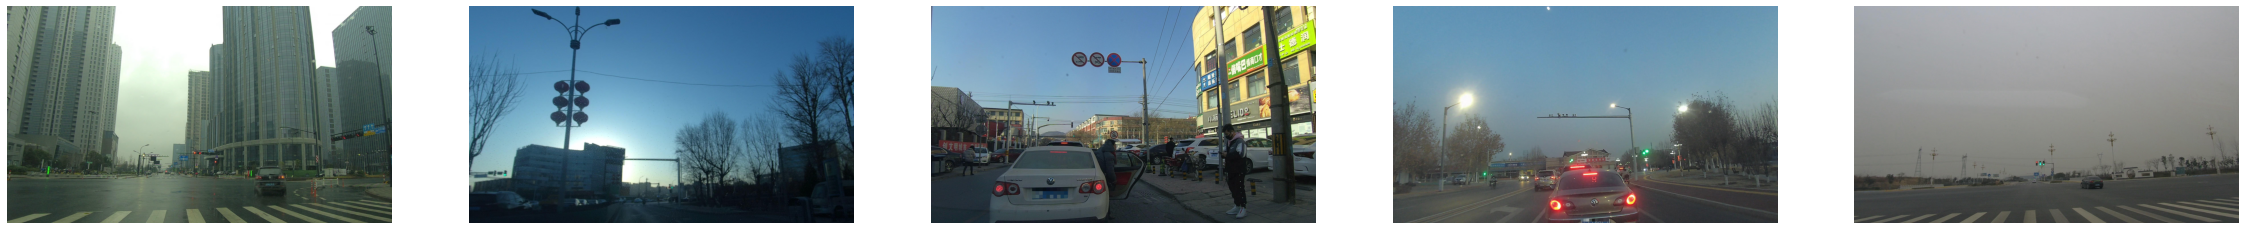

In [ ]:
list_name = []
list_imgs = []
train_imgPath = '/content/traffic-light-detection-dataset/train_dataset/train_images'

for (dirname, dirs, files) in os.walk(train_imgPath):
    for filename in files:
      list_name.append(filename)

for k in range(5):
  numberjpg = choice(list_name)
  img = f'/content/traffic-light-detection-dataset/train_dataset/train_images/{numberjpg}'
  list_imgs.append(img)

fig, ax = plt.subplots(ncols=5, figsize=(40,20))
img0 = plt.imread(list_imgs[0])
ax[0].imshow(img0)
ax[0].axis('off')
img1 = plt.imread(list_imgs[1])
ax[1].imshow(img1)
ax[1].axis('off')
img2 = plt.imread(list_imgs[2])
ax[2].imshow(img2)
ax[2].axis('off')
img3 = plt.imread(list_imgs[3])
ax[3].imshow(img3)
ax[3].axis('off')
img4 = plt.imread(list_imgs[4])
ax[4].imshow(img4)
ax[4].axis('off')

plt.show()

In [ ]:
def gen_number():
  i = random.randint(0, 3)
  j = random.randint(0, 9)
  k = random.randint(0, 9)
  m = random.randint(0, 9)
  x = i*1000+j*100+k*10+m
  while x > 3000:
    i = random.randint(0, 3)
    j = random.randint(0, 9)
    k = random.randint(0, 9)
    m = random.randint(0, 9) 
    x = i*1000+j*100+k*10+m
  num = f'0{i}{j}{k}{m}'
  return num

In [ ]:
i = gen_number()
type(i)

str

**Checking the correctness of buond boxes.**
We know that in the first image of the train dataset there are three traffic light. Let's see if they are corrected bounded.

In [ ]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

In [ ]:
ann = json.load(open('/content/traffic-light-detection-dataset/train_dataset/train.json',))
ann = ann['annotations']
len(ann)


14896

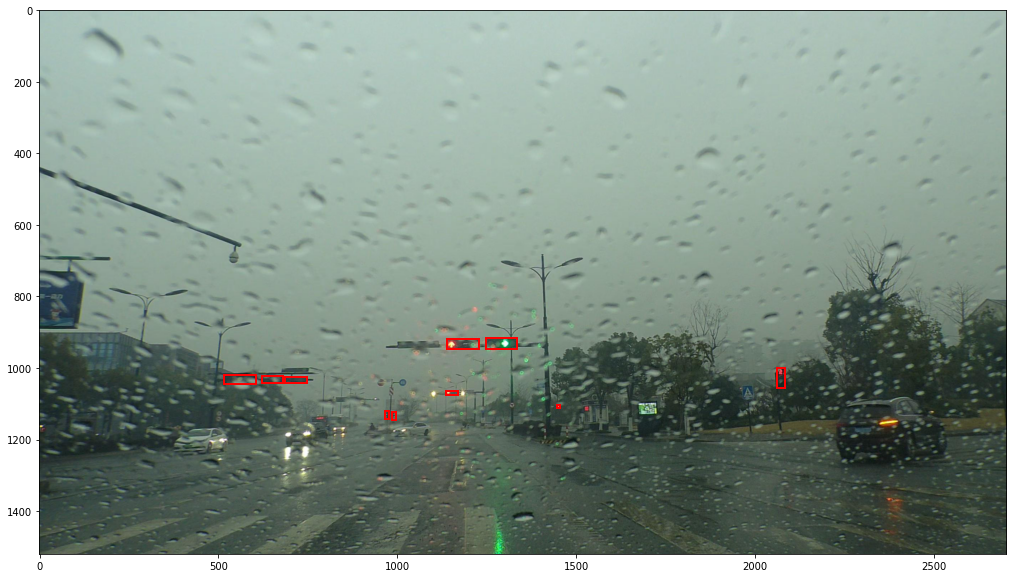

In [ ]:
i = gen_number()
bnd_img = []
for j in range(0, len(ann)):
  if i in ann[j]['filename']:
    box = ann[j]['bndbox']
    l = []
    l.append(box['xmin'])
    l.append(box['ymin'])
    l.append(box['xmax'])
    l.append(box['ymax'])
    bnd_img.append(l)

imgpath = f'/content/traffic-light-detection-dataset/train_dataset/train_images/{i}.jpg'
img = plt.imread(imgpath)

plt.subplots(figsize = (20, 10))
fig = plt.imshow(img)
for k in range(0, len(bnd_img)):
  fig.axes.add_patch(bbox_to_rect(bnd_img[k], 'red'))

## **Building-model phase**

Before moving on to the model-building phase, we need to correctly annotate the training images so that we can use them to train the yolo network. To do this, we used the online tool 'Roboflow' (available at https://roboflow.com/). Both the folder containing all the train images and the json file containing all the annotations were passed to the online tool Roboflow. From this, two folders were obtained: one containing the images and the other containing the text files (labels) with the co-ordinates of all the traffic lights written in them. The traffic lights are classified into four different classes: 'red', 'yellow', 'green' and 'object'. The first three are the traffic lights that are on in the images, those that are not to be ignored (i.e. those that have the entry 'ignore : 0' in the json file), while the traffic lights of the last class are those that are off in the images.

In [ ]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
print('')
print('Change work directory in: ')
print('')
%cd yolov5
print('')
print('Install dependecies: ')
print('')
!pip install -r requirements.txt # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 14215, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 14215 (delta 6), reused 6 (delta 2), pack-reused 14194
Receiving objects: 100% (14215/14215), 13.35 MiB | 30.64 MiB/s, done.
Resolving deltas: 100% (9821/9821), done.

Change work directory in: 

/content/yolov5

Install dependecies: 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.7 MB/s 


If you are using Google Colab, you must load the resulting datasets from roboflow.

If the zip file resulting from the execution of the Roboflow online tool is located within your Drive folder, you can retrieve it by linking your Google Drive account to the Google Colab work folder.

In [ ]:
drive.mount('/content/drive')

shutil.copy(r'/content/drive/MyDrive/Roboflow_data_yolov5.zip', r'/content/yolov5/')


Mounted at /content/drive


'/content/yolov5/Roboflow_data_yolov5.zip'

Alternatively, you can upload the resulting zip file of the Roboflow execution using the following code.

In [ ]:
files.upload()

Once the .zip file has been uploaded, we first unzip it, then we notice that there are two folders inside, 'train' and 'test', containing respectively the train images with their labels, and the test images, obviously without any labels. We note that initially there is no validation set, which allows us to evaluate the performance of the model. To overcome this problem, we decide to take a part (about 20%) of the train images, with their labels, and generate the validation set.
Within the previously decompressed folder, there is also a 'data.yaml' file containing the paths to the training and validation dataset, and the object classes are specified.

In [ ]:
!unzip Roboflow_data_yolov5.zip -d Roboflow_data
shutil.move(r'/content/yolov5/Roboflow_data/data.yaml', r'/content/yolov5')
!mkdir /content/yolov5/Roboflow_data/val
!mkdir /content/yolov5/Roboflow_data/val/images
!mkdir /content/yolov5/Roboflow_data/val/labels

Streaming output truncated to the last 5000 lines.
  inflating: Roboflow_data/train/images/00238_jpg.rf.d4bf9cd1e22e4f3f8eb979ee7f83ce08.jpg  
  inflating: Roboflow_data/train/images/00239_jpg.rf.2b6dab59b6de87d7441fac49e5b95602.jpg  
  inflating: Roboflow_data/train/images/00240_jpg.rf.dcca3f503e7a9385b9813e061cdfe98e.jpg  
  inflating: Roboflow_data/train/images/00242_jpg.rf.66410bda16159032d8085bc3c4f40871.jpg  
  inflating: Roboflow_data/train/images/00243_jpg.rf.5b5cdc80adbc35d1380cad5606e851c7.jpg  
  inflating: Roboflow_data/train/images/00244_jpg.rf.74e5febb39394ca0e75b6d6c41cbfbc1.jpg  
  inflating: Roboflow_data/train/images/00245_jpg.rf.26467e58b12ae131647f4a5527eec60d.jpg  
  inflating: Roboflow_data/train/images/00246_jpg.rf.02c40ffc4d5d0caf9a3b0be622e164d2.jpg  
  inflating: Roboflow_data/train/images/00247_jpg.rf.d8a92053e91790e8f9da48f1cec5443f.jpg  
  inflating: Roboflow_data/train/images/00248_jpg.rf.7aed991c0b450fc3b5f49c1848eb6deb.jpg  
  inflating: Roboflow_data/tr

In [ ]:
#arrays to store file names
imgs =[]
xmls =[]

#setup dir names
val_imgPath = '/content/yolov5/Roboflow_data/val/images'
train_imgPath = '/content/yolov5/Roboflow_data/train/images' #dir where images and annotations stored
val_labPath = '/content/yolov5/Roboflow_data/val/labels'
train_labPath = '/content/yolov5/Roboflow_data/train/labels'

#setup ratio (val ratio = rest of the files in origin dir after splitting into train and test)
train_ratio = 0.8
val_ratio = 0.2

#soring files to corresponding arrays
for (dirname, dirs, files) in os.walk(train_imgPath):
    for filename in files:
      imgs.append(filename)

for (dirname, dirs, files) in os.walk(train_labPath):
    for filename in files:
      xmls.append(filename)

#counting range for cycles
countForTrain = int(len(imgs)*train_ratio)
countForVal = int(len(imgs)*val_ratio)
print("training images are : ", countForTrain)
print("Validation images are : ", countForVal)

training images are :  2080
Validation images are :  520


In [ ]:
print(imgs[0:10])
print('')
print(xmls[0:10])

['00254_jpg.rf.1c27af4ef56a0f78230c776272a2ac93.jpg', '02873_jpg.rf.27f55cf7d30df468f9031aa51907790f.jpg', '02288_jpg.rf.3ece7428f2c8279cc330d882c6620119.jpg', '02731_jpg.rf.38368f180f4bf33db1779cdde3ccc863.jpg', '02802_jpg.rf.6502f191810af1f87660d5d2c8339736.jpg', '02002_jpg.rf.ac568805468cf583c632fcb4828f139c.jpg', '02132_jpg.rf.3fd610a3b1beee9bd6fe5f7a7ec800d8.jpg', '01874_jpg.rf.1ba525624d1adda03f885d33fd0fa728.jpg', '00582_jpg.rf.cfda1293bedac7671665a3917f6ca1c6.jpg', '00479_jpg.rf.c01403b165a728107d2bf66550fdc41d.jpg']

['02506_jpg.rf.3d3efcde12155b92ed519953e407cc96.txt', '02283_jpg.rf.a471240e2b2b8b8738ba1dc50d759878.txt', '00005_jpg.rf.47a683860f14bb7b593c7e541a05aab9.txt', '00983_jpg.rf.2c6a9a22884847d1a65f0f2485c1efc7.txt', '02712_jpg.rf.06c8b1dda3db0fc843f0d9cdbd51ed7d.txt', '01031_jpg.rf.ed0f759aadae57569de8c99c2d41bc29.txt', '01293_jpg.rf.279dd09780238d921c39621945942943.txt', '01130_jpg.rf.3f4a70e62acab7f73e1790af03988e1f.txt', '02739_jpg.rf.9ecc5b93a19bd61eca15109019c85

In [ ]:
for x in range(countForVal):

    fileJpg = choice(imgs) # get name of random image from origin dir
    fileXml = fileJpg[:-4] +'.txt' # get name of corresponding annotation file

    #move both files into train dir
    shutil.move(os.path.join(train_imgPath, fileJpg), os.path.join(val_imgPath, fileJpg))
    shutil.move(os.path.join(train_labPath, fileXml), os.path.join(val_labPath, fileXml))
    
    #remove files from arrays
    imgs.remove(fileJpg)
    xmls.remove(fileXml)

At this point we can move on to the training phase of the model. We decided to train the model using yolov5's 's' weights, which performed well, with batch equals 16 and a number of epochs equal to 30.

In [ ]:
!python train.py --img 415 --batch 16 --epochs 30 --data data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=415, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-198-gacff977 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, deg

Let us now look at the statistics obtained from the training phase of the model and how the model was able to recognise the traffic lights from the images in the validation set.

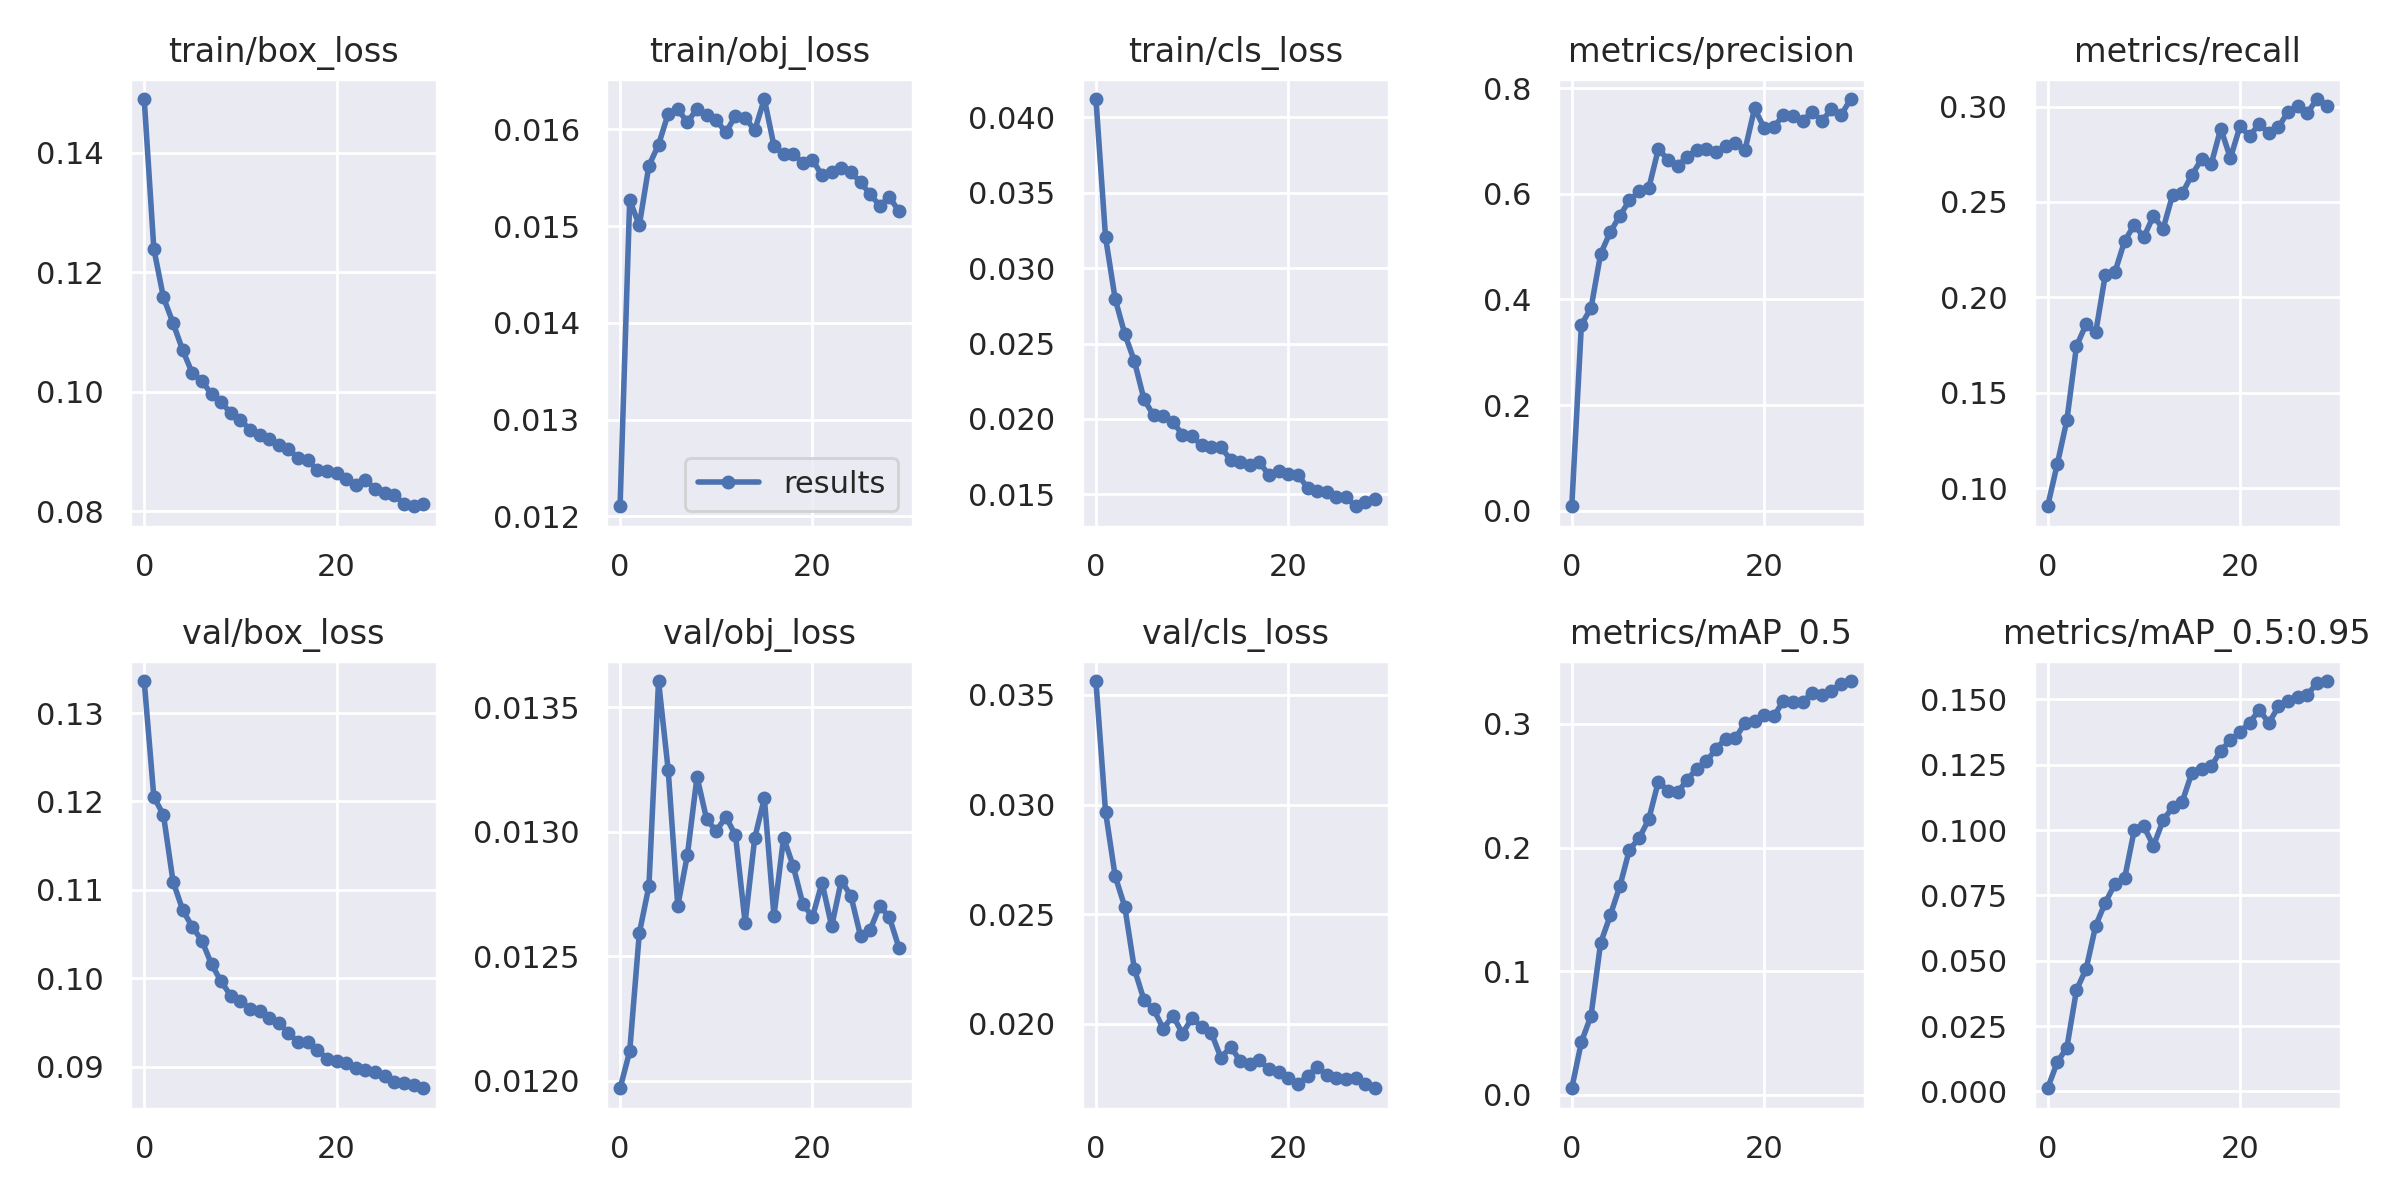

In [ ]:
Image(filename = '/content/yolov5/runs/train/exp/results.png', width = 1200)

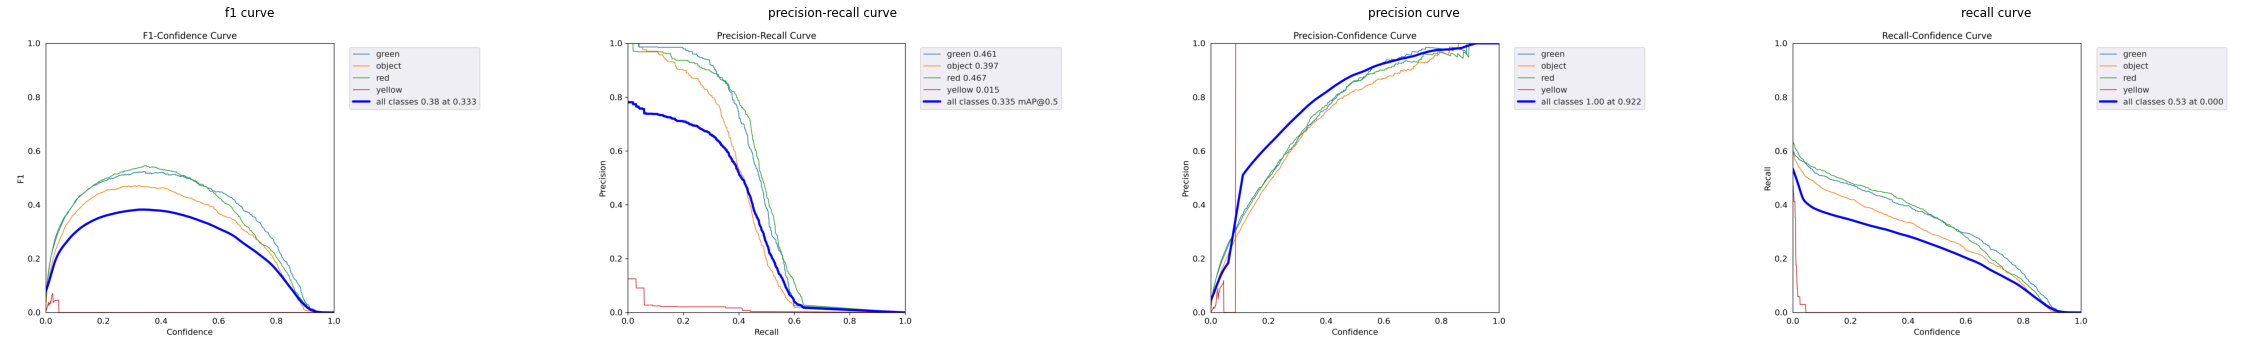

In [ ]:
f1curve = plt.imread('/content/yolov5/runs/train/exp/F1_curve.png')
prcurve = plt.imread('/content/yolov5/runs/train/exp/PR_curve.png')
pcurve = plt.imread('/content/yolov5/runs/train/exp/P_curve.png')
rcurve = plt.imread('/content/yolov5/runs/train/exp/R_curve.png')

fig, ax = plt.subplots(ncols=4, figsize=(40,20))

ax[0].set_title('f1 curve')
ax[0].imshow(f1curve)
ax[0].axis('off')

ax[1].set_title('precision-recall curve')
ax[1].imshow(prcurve)
ax[1].axis('off')

ax[2].set_title('precision curve')
ax[2].imshow(pcurve)
ax[2].axis('off')

ax[3].set_title('recall curve')
ax[3].imshow(rcurve)
ax[3].axis('off')

plt.show()

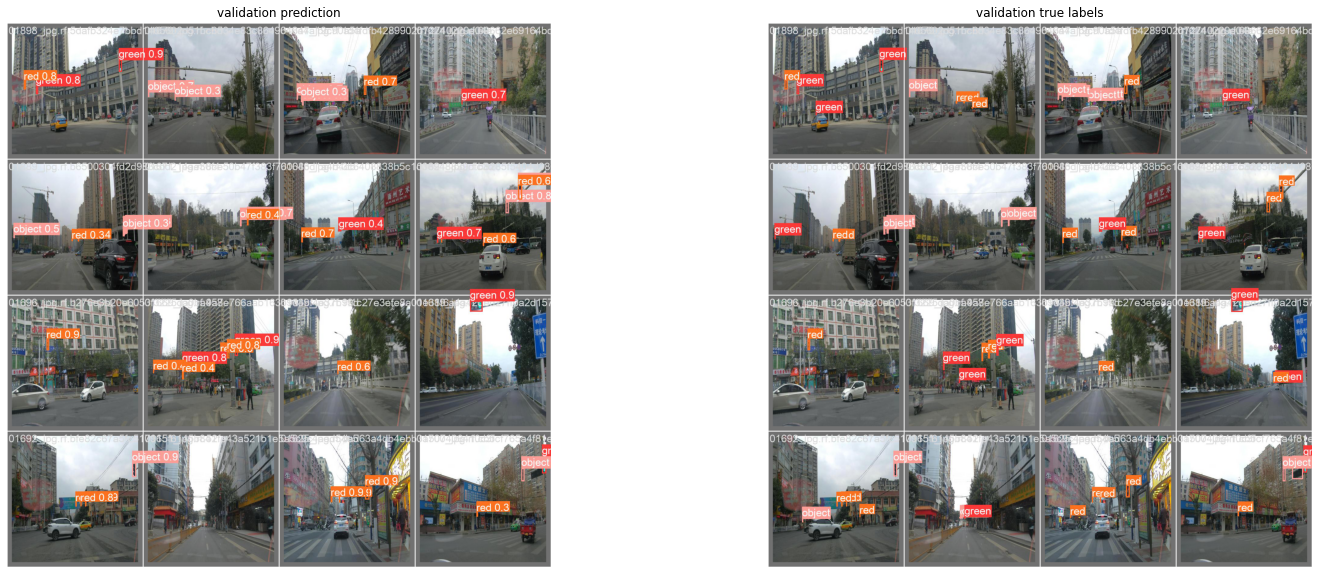

In [ ]:
valpred = plt.imread('/content/yolov5/runs/train/exp/val_batch2_pred.jpg')
vallabels = plt.imread('/content/yolov5/runs/train/exp/val_batch2_labels.jpg')

fig, ax = plt.subplots(ncols=2, figsize=(25,10))

ax[0].set_title('validation prediction')
ax[0].imshow(valpred)
ax[0].axis('off')

ax[1].set_title('validation true labels')
ax[1].imshow(vallabels)
ax[1].axis('off')

plt.show()

## **Testing phase**

At this point, we use the network to try to recognise traffic lights in images it has never seen. To do this, we use the images from the test set.

In [ ]:
imges = []

test_path = '/content/yolov5/Roboflow_data/test/test_images'

for (dirname, dirs, files) in os.walk(test_path):
    for filename in files:
      imges.append(filename)

count_test = len(imges)
print(count_test)

400


In [ ]:
testJpg = choice(imges)

!python detect.py --source Roboflow_data/test/test_images/{testJpg} --weights runs/train/exp/weights/best.pt --data data.yaml --conf 0.25

detect: weights=['runs/train/exp/weights/best.pt'], source=Roboflow_data/test/test_images/00938.jpg, data=data.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-198-gacff977 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/Roboflow_data/test/test_images/00938.jpg: 384x640 3 greens, 4 objects, 12.1ms
Speed: 0.5ms pre-process, 12.1ms inference, 1.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp4


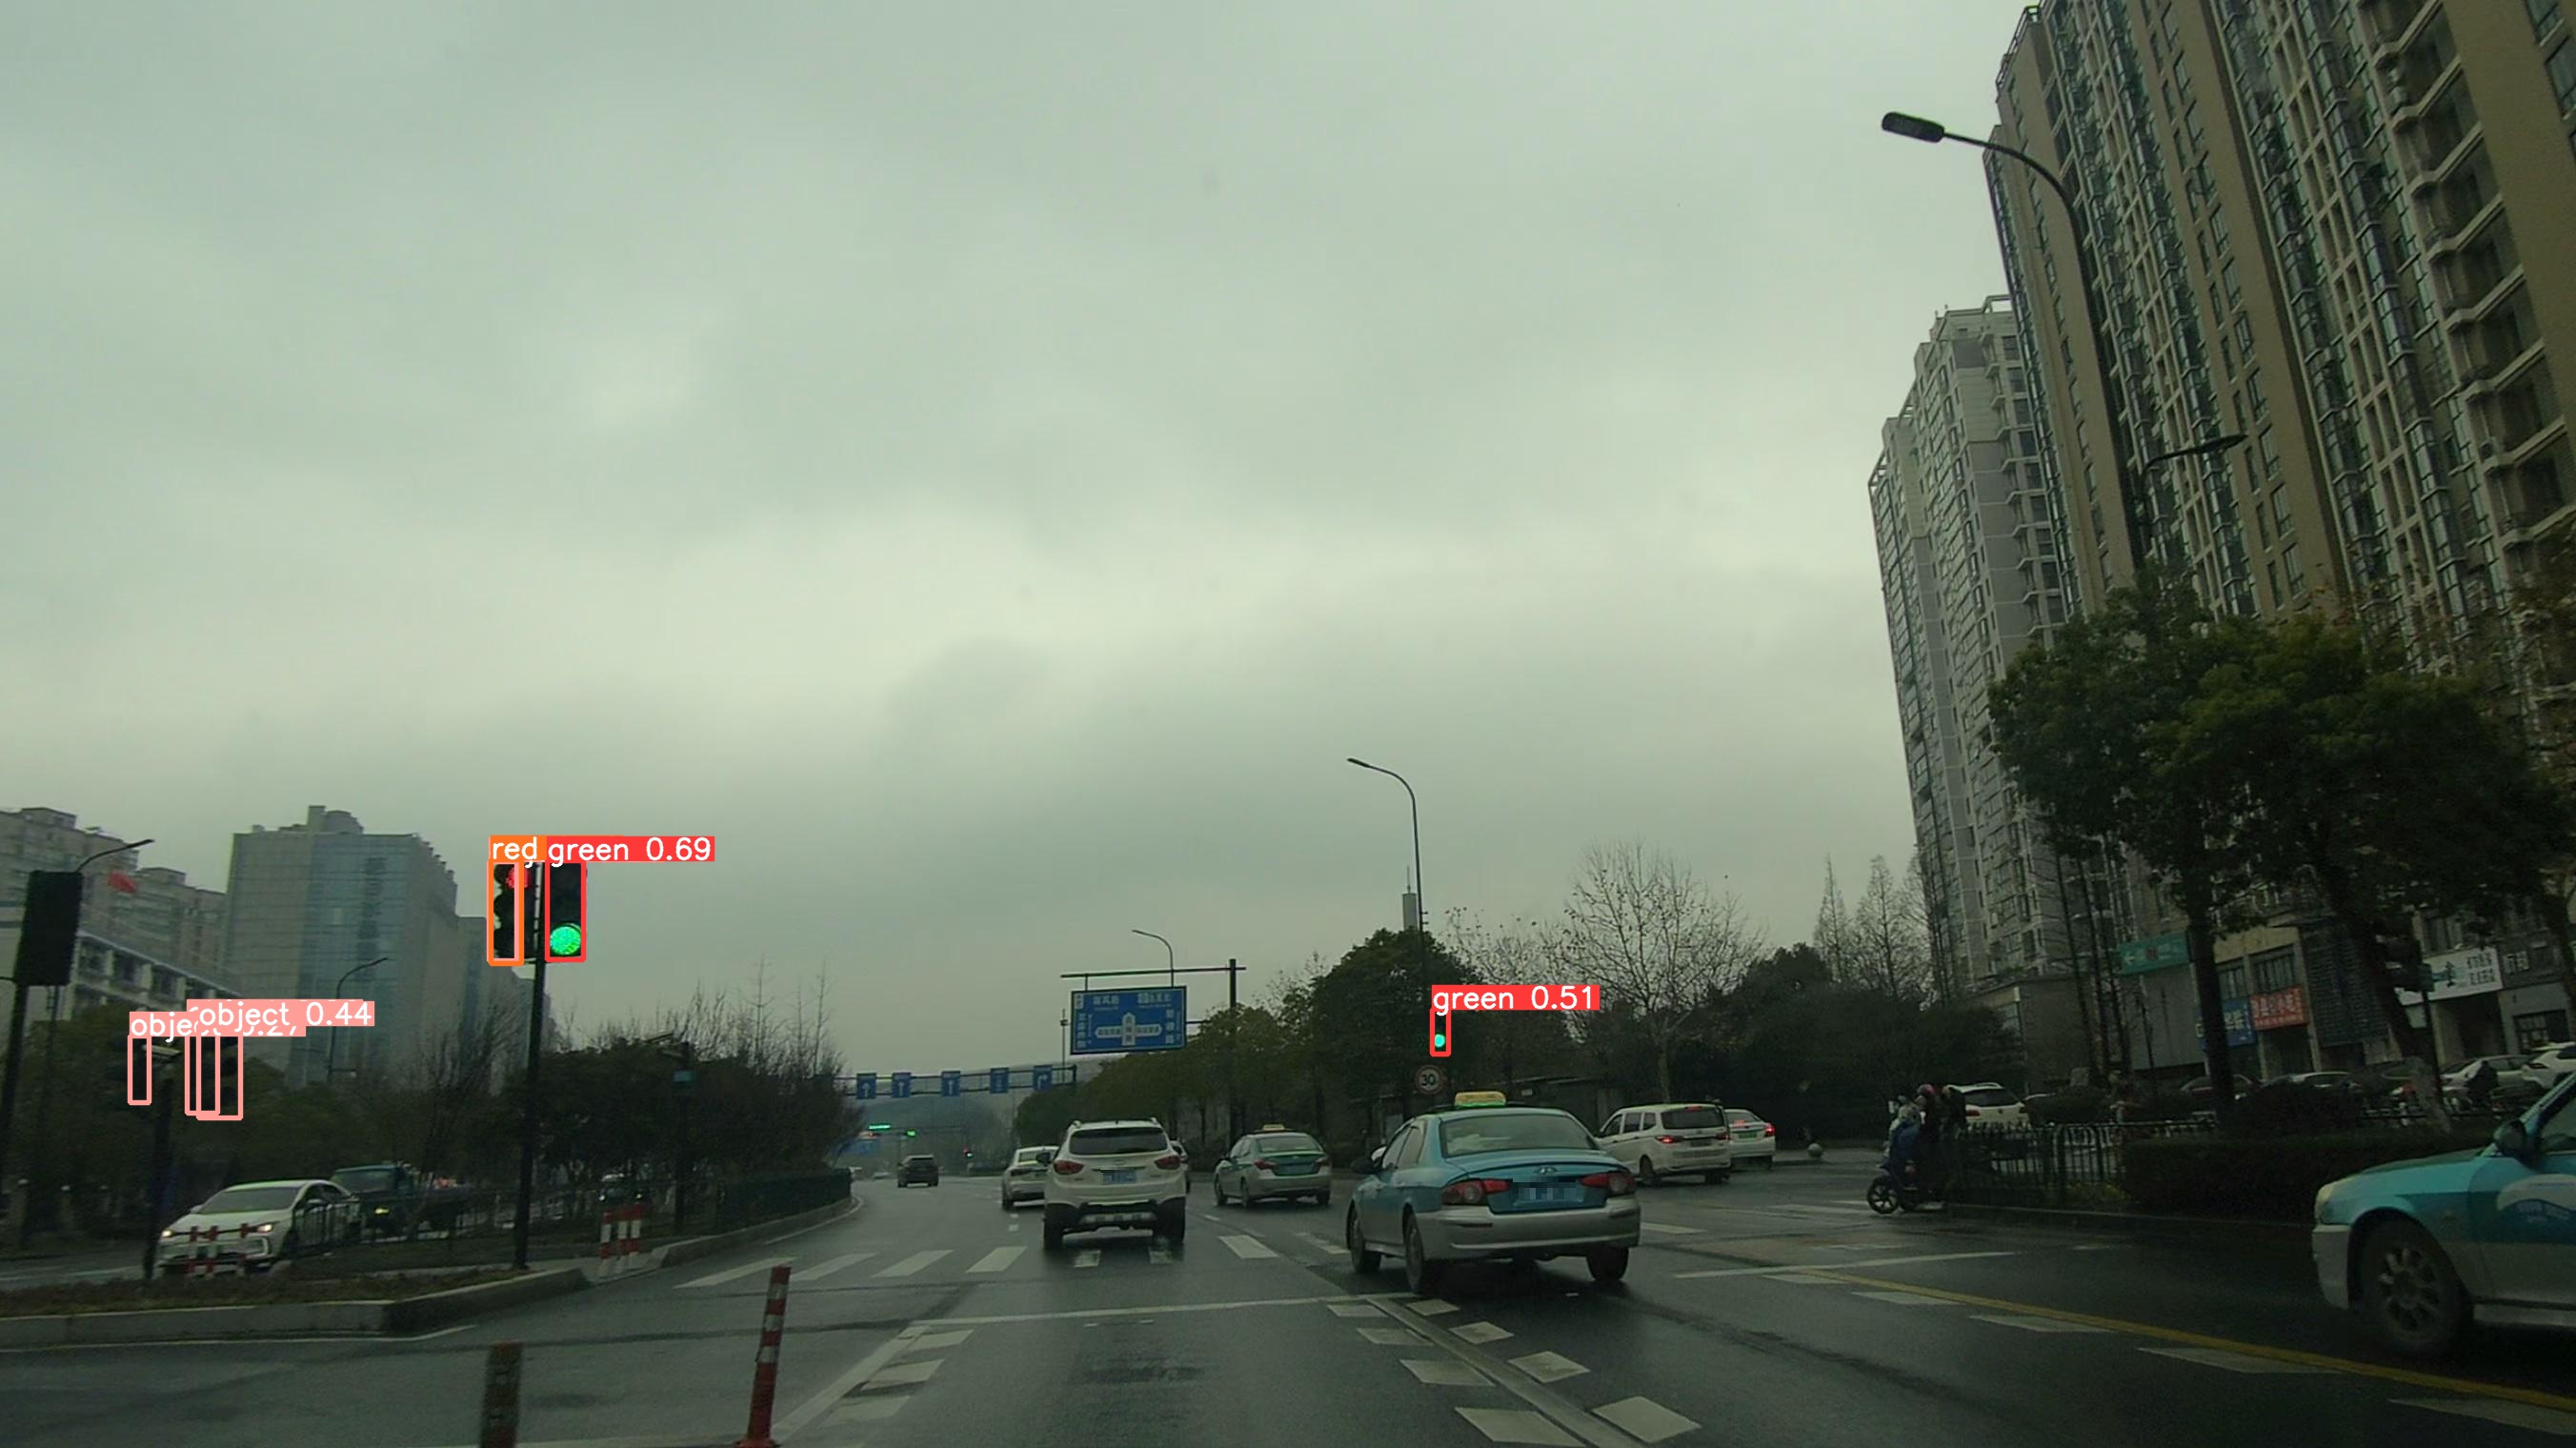

In [ ]:
exps_list = []
detected_images = []
walk = 'runs/detect'

for (dirname, dirs, files) in os.walk(walk):
    for filename in dirs:
      exps_list.append(filename)

exp = choice(exps_list)

for (dirname, dirs, files) in os.walk(f'{walk}/{exp}'):
    for filename in files:
      detected_images.append(filename)

detected_image = choice(detected_images)

Image(filename= f'runs/detect/{exp}/{detected_image}', width=1200)